# Table of Contents
 <p><div class="lev1 toc-item"><a data-toc-modified-id="erythropus-1" href="#erythropus"><span class="toc-item-num">1&nbsp;&nbsp;</span>erythropus</a></div><div class="lev1 toc-item"><a data-toc-modified-id="parallelus-2" href="#parallelus"><span class="toc-item-num">2&nbsp;&nbsp;</span>parallelus</a></div><div class="lev2 toc-item"><a data-toc-modified-id="retry-two_epoch-model-with-PAR-spectrum-21" href="#retry-two_epoch-model-with-PAR-spectrum"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>retry two_epoch model with PAR spectrum</a></div><div class="lev1 toc-item"><a data-toc-modified-id="retry-two_epoch-model-with-ery-spectrum-3" href="#retry-two_epoch-model-with-ery-spectrum"><span class="toc-item-num">3&nbsp;&nbsp;</span>retry two_epoch model with ery spectrum</a></div>

# erythropus

I am going to use the same parallel framework as used for the `bottlegrowth` model, i. e. using the `subprocess` module to spawn different processes for different optimisations and using `pgrep` together with `kill` to abort jobs that run too long. For smaller optimisations, I am going to use `ipyparallel`.

I have written a python script called `run_dadi.py`, which can take many command line arguments and in the following parallel framework is the replacement for the `run_dadi` function used previously.

In [1]:
%less run_dadi.py

In [2]:
! ./run_dadi.py -h

usage: run_dadi.py [-h] [-p PATH_TO_SPECTRUM_FILE] [-m DADI_MODEL] [-u UPPER]
                   [-l LOWER] [-i P_INIT] [-d DADI_OPT_FUNC] [-s STUB]
                   [--maxiter MAXITER]

runs dadi optimisation of parameters for given model

optional arguments:
  -h, --help            show this help message and exit
  -p PATH_TO_SPECTRUM_FILE, --path_to_spectrum_file PATH_TO_SPECTRUM_FILE
                        file path to site frequency data
  -m DADI_MODEL, --dadi_model DADI_MODEL
                        model function to use
  -u UPPER, --upper UPPER
                        upper parameter bound
  -l LOWER, --lower LOWER
                        lower parameter bound
  -i P_INIT, --p_init P_INIT
                        initial parameter values
  -d DADI_OPT_FUNC, --dadi_opt_func DADI_OPT_FUNC
                        dadi optimisation function to use
  -s STUB, --stub STUB  file name stub for output files
  --maxiter MAXITER     maximum number of iterations allowed


In [1]:
import multiprocessing
import subprocess32 as subprocess
import time, signal, os, pickle
import numpy as np

In [4]:
multiprocessing.cpu_count()

24

In [2]:
import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

In [55]:
?dadi.Demographics1D.three_epoch

The built-in `three_epoch` model specifies a piecewise history (with only instantaneous population size changes instead of gradual changes). At time $TF+TB$ the ancient population underwent a size change, stayed at this size for $TB \times 2N_{ref}$ generations and then underwent a second size size change $TF \times 2N_{ref}$ generations in the past to the contemporary population size. The model has therefore two population size parameters, $\nu_B$ and $\nu_F$ as well as two time parameters, $TB$ and $TF$.

In [5]:
# set lower and upper bounds to nuB, nuF and T
upper_bound = [1e4, 1e4, 4, 4]
lower_bound = [1e-4, 1e-4, 0, 0]

In [6]:
# create range of starting values evenly distributed in log space
p0_nuB = np.logspace(-3, 3, base=10.0, num=6)
p0_nuF = np.logspace(-3, 3, base=10.0, num=6)
p0_TF = np.logspace(-4, np.log10(4), base=10, num=6)
p0_TB = np.logspace(-4, np.log10(4), base=10, num=6)

In [7]:
print "There are %d starting parameter values" % (6**4)

There are 1296 starting parameter values


These are already an enormous amount of parameter combinations. I think I will need to keep `maxiter` low so that optimisations that do not converge early end more quickly when they hit the maximum number of iterations. I will also frequently have to prune the available cores of optimisation runs that have already taken a considerable amount of time. This can be done with the following command:

    pgrep -of "python ./run_dadi.py" | xargs kill

The following variables will be passed as string values to `run_dadi.py`:

In [8]:
path_to_spectrum_file = "dadiExercises/ERY.FOLDED.sfs.dadi_format"
dadi_model = "dadi.Demographics1D.three_epoch"
upper = str(upper_bound)
lower = str(lower_bound)
dadi_opt_func = "dadi.Inference.optimize_log_fmin" # Nelder-Mead
stub = "ERY_three_epoch_NM"
maxiter = 10 # keep maxiter low, but not too low to allow convergence of some optimisations

In [11]:
%run run_dadi.py -h

usage: run_dadi.py [-h] [-p PATH_TO_SPECTRUM_FILE] [-m DADI_MODEL] [-u UPPER]
                   [-l LOWER] [-i P_INIT] [-d DADI_OPT_FUNC] [-s STUB]
                   [--maxiter MAXITER]

runs dadi optimisation of parameters for given model

optional arguments:
  -h, --help            show this help message and exit
  -p PATH_TO_SPECTRUM_FILE, --path_to_spectrum_file PATH_TO_SPECTRUM_FILE
                        file path to site frequency data
  -m DADI_MODEL, --dadi_model DADI_MODEL
                        model function to use
  -u UPPER, --upper UPPER
                        upper parameter bound
  -l LOWER, --lower LOWER
                        lower parameter bound
  -i P_INIT, --p_init P_INIT
                        initial parameter values
  -d DADI_OPT_FUNC, --dadi_opt_func DADI_OPT_FUNC
                        dadi optimisation function to use
  -s STUB, --stub STUB  file name stub for output files
  --maxiter MAXITER     maximum number of iterations allowed


In [9]:
from itertools import product

In [10]:
# check creation of command line

for i, p_init in enumerate(product(p0_nuB, p0_nuF, p0_TF, p0_TB)):
    cmd = "./run_dadi.py -p %s -m %s -u '%s' -l '%s' -d %s -s %s --maxiter %s -i '%s'" \
                % (path_to_spectrum_file, dadi_model, upper, lower, dadi_opt_func, stub, str(maxiter), str(p_init))
    print cmd
    if i >= 0: break

./run_dadi.py -p dadiExercises/ERY.FOLDED.sfs.dadi_format -m dadi.Demographics1D.three_epoch -u '[10000.0, 10000.0, 4, 4]' -l '[0.0001, 0.0001, 0, 0]' -d dadi.Inference.optimize_log_fmin -s ERY_three_epoch_NM --maxiter 10 -i '(0.001, 0.001, 0.0001, 0.0001)'


Next, I need to define an executor class that takes care of submiting jobs as slots become available. This is taken from [Tiago Antao's Cookbook](http://tiago.org/):

In [12]:
class executor:
    def __init__(self, limit):
        self.limit = limit
        self.ncores = multiprocessing.cpu_count()
        self.running = []
        self.finished = 0

    def submit(self, cmd, p_init):
        self.wait() 
        if hasattr(self, 'out'):
            out = self.out
        else:
            out = '/dev/null'
        if hasattr(self, 'err'):
            err = self.err
        else:
            err = '/dev/null'
        if err == 'stderr':
            errSt = ''
        else:
            errSt = '2> ' + err
        # this is where the magic happens:
        proc = subprocess.Popen('%s > %s %s' % (cmd, out, errSt), shell=True)
        self.running.append(proc)
        #
        if hasattr(self, 'out'):
            del self.out
        if hasattr(self, 'err'):
            del self.err
            
    def wait(self, for_all=False):
        self.clean_done()
        #numWaits = 0
        if self.limit > 0 and type(self.limit) == int:
            cond = 'len(self.running) >= self.ncores - self.limit'
        elif self.limit < 0:
            cond = 'len(self.running) >= - self.limit'
        else:
            cond = 'len(self.running) >= self.ncores * self.limit'
        while eval(cond) or (for_all and len(self.running) > 0):
            time.sleep(1)
            self.clean_done() # updates self.running, removes finished jobs from the running queue
            #numWaits += 1
            
    def clean_done(self):
        terminated = []
        for i, p in enumerate(self.running):
            if p.poll() is not None: # None means it's still running
                terminated.append(i)
        for idx in reversed(terminated):
            del self.running[idx]
            self.finished += 1
            
    def progress(self):
        self.clean_done()
        print self.finished

In [ ]:
E = executor(limit=-18) # use up to 18 cores

# this will block
for i, p_init in enumerate(product(p0_nuB, p0_nuF, p0_TF, p0_TB)):
    cmd = "./run_dadi.py -p %s -m %s -u '%s' -l '%s' -d %s -s %s --maxiter %s -i '%s'" \
                % (path_to_spectrum_file, dadi_model, upper, lower, dadi_opt_func, stub, str(maxiter), str(p_init))
    E.err = "stderr"
    E.submit(cmd, p_init)

After 191 output file had been created, I loaded those pickle files into another notebook (because the upper command blocks the current session). A check of the returned optimisation flags showed that all 191 optimisations had reached the maximum number of iterations, i. e. none had converged.

After 414 optimisations without a single successful optimisation, I have decided to abort this sweep through the parameter space. Due to the size of the parameter space, even with just 6 samples per parameter, increasing the maximum number of allowed iterations per optimisation is not an option due to prohibitive running time given this is still an exploratory analysis.

I think my only option of finding optimal parameter values for this model is to start at some reasonable combination of parameters, perturb them and run optimisations with those slightly perturbed initial parameter values.

Let's first try to do this with `ipyparallel`.

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy as np

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

In [5]:
%ll

total 2300
-rw-rw-r-- 1 claudius 671626 Apr 22 08:22 01_dadi_1D_exp_growth.ipynb
-rw-rw-r-- 1 claudius 248481 Apr 22 11:27 02_dadi_1D_two_epoch.ipynb
-rw-rw-r-- 1 claudius 148443 Apr 22 12:25 03_1D_bottlegrowth.ipynb
-rw-rw-r-- 1 claudius  97634 Apr 22 15:54 04_1D_three_epoch.ipynb
-rw-rw-r-- 1 claudius 297053 Apr 22 15:51 05_1D_model_synthesis.ipynb
-rw-rw-r-- 1 claudius 118564 Apr 20 16:47 05_2D.ipynb
-rw-rw-r-- 1 claudius 444729 Apr 21 10:05 1D_models.ipynb
-rw-rw-r-- 1 claudius  33125 Apr  8 18:15 1D_two_epoch_opt_res_ERY.dill
-rw-rw-r-- 1 claudius  16613 Apr  8 19:18 1D_two_epoch_opt_res_PAR.dill
drwxrwxr-x 4 claudius   4096 Apr 20 10:19 dadiExercises/
-rw-rw-r-- 1 claudius  36308 Apr  3 20:33 ery_fold_comp.png
-rw-rw-r-- 1 claudius   3560 Mar 25 08:40 EryPar.FOLDED.2dsfs
-rw-rw-r-- 1 claudius    433 Mar 24 20:15 ERY.unfolded.sfs
-rw-rw-r-- 1 claudius    421 Mar 24 20:14 ERY.unfolded.sfs~
-rw-rw-r-- 1 claudius  13913 Apr  6 15:03 exp_growth_optim_res_ERY.pickle
-rw-rw-r-- 1 claudi

In [6]:
! cat ERY.unfolded.sfs

37 unfolded
1592046.636125 7148.627587 6831.828430 3473.268669 3417.591990 2249.932322 1980.824357 1011.763357 2262.489617 557.169754 1049.858226 1159.694611 768.373223 1125.393799 448.462048 544.635916 1014.348661 147.731786 975.251801 233.415985 851.137519 12.642136 803.134099 0.128476 567.179523 446.009983 158.967094 484.096759 372.705620 540.860079 95.276852 808.290844 234.084809 614.920896 625.008059 890.804592 2515.454396 


In [3]:
%%px --local

# import 1D spectrum of ery on all engines:
fs_ery = dadi.Spectrum.from_file('ERY.unfolded.sfs').fold()

# import 1D spectrum of ery on all engines:
fs_par = dadi.Spectrum.from_file('PAR.unfolded.sfs').fold()

In [4]:
%%px --local

ns = fs_ery.sample_sizes # both populations have the same sample size

fs_ery.pop_ids = ['ery']
fs_par.pop_ids = ['par']

# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [50, 60, 70]

In [5]:
%%px --local

# create link to function that specifies the model
func = dadi.Demographics1D.three_epoch

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

In [6]:
%%px

# set lower and upper bounds to nuB, nuF and T
upper_bound = [1e4, 1e4, 4, 4]
lower_bound = [1e-4, 1e-4, 0, 0]

In [7]:
# create load balanced view of engines

lbview = cl.load_balanced_view()

In [12]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    return p_init, popt

In [26]:
%%px

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = fs_ery # use ERY spectrum
perturb = True
fold = 2
maxiter = 20 # run a maximum of 20 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)

In [8]:
from itertools import repeat

In [27]:
# specify the initial parameter values, they will be randomly perturbed by up to a factor of 2
p0 = [1, 1, 1, 1]
# these parameters indicate no size changes at times 1 and 2 (x 2N) generations in the past

ar_ery = lbview.map(run_dadi, repeat([1, 1, 1, 1], 40), block=False, order=True)

In [28]:
ar_ery.wall_time

8.650946

In [9]:
def get_flag_count(out, NM=True):
    """
    out: list of tuples, each containing p_init and popt + additional info, including warnflags
    as produced by run_dadi.py
    """
    from collections import defaultdict
    
    if NM: # if ar from Nelder-Mead
        i = 4 # the warnflag is reported at index position 4 in the output array
    else: # ar from BFGS optimisation
        i = 6
    
    warnflag = defaultdict(int)

    for res in out:
        if res[1][i] == 1: # notice the change in indexing
            warnflag[1] +=1
        elif res[1][i] == 2:
            warnflag[2] += 1
        elif res[1][i] == 0:
            warnflag[0] += 1
        else:
            warnflag[999] +=1
    if NM:
        print "success", warnflag[0]
        print "Maximum number of function evaluations made.", warnflag[1]
        print "Maximum number of iterations reached.", warnflag[2]
        print "unknown flag", warnflag[999]
    else:
        print "success", warnflag[0]
        print "Maximum number of iterations exceeded.", warnflag[1]
        print "Gradient and/or function calls not changing.", warnflag[2]
        print "unknown flag", warnflag[999]

In [30]:
get_flag_count(ar_ery, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 40
unknown flag 0


OK, I obviously need to increase the number of iterations. Since the upper run was extremely fast, I am bold enough to increase `maxiter` to 100.

In [31]:
%%px

maxiter = 100

In [32]:
cl[0]['maxiter']

100

In [33]:
# run 40 optimisations with perturbed p0 and maxiter=100

ar_ery = lbview.map(run_dadi, repeat(p0, 40), block=False, order=False)

In [36]:
ar_ery.wall_time

176.171281

In [37]:
get_flag_count(ar_ery, NM=True)

success 7
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 33
unknown flag 0


In [38]:
for out in ar_ery:
    if out[1][4] == 0:
        print out[1][0], out[1][1]

[ 1.85654414  0.24992367  2.21238517  1.25368939] 2168.11186438
[ 1.55644243  0.26882739  0.18443449  1.18648075] 2168.11186793
[ 5.54171522  0.85587957  2.14281429  3.38509467] 2168.11188321
[ 0.32211174  0.22622996  0.15448801  0.94006958] 2168.11186656
[ 0.95664403  0.33589903  0.15976201  1.34434968] 2168.11187225
[ 2.41036662  0.21918639  0.16579024  1.03361692] 2168.11186581
[ 0.03328397  0.11515687  3.99449464  3.37126089] 2173.46212955


In [11]:
import dill

In [141]:
# save optimisation results to file

dill.dump(list(ar_ery.get()), open("OUT_three_epoch/ERY_perturb_ar_ery.dill", "w"))

In [10]:
def flatten(array):
    """
        Returns a list of flattened elements of every inner lists (or tuples)
        ****RECURSIVE****
    """
    import numpy
    res = []
    for el in array:
        if isinstance(el, (list, tuple, numpy.ndarray)):
            res.extend(flatten(el))
            continue
        res.append(el)
    return list( res )

In [42]:
successfull_popt = [flatten(out)[:9] for out in ar_ery if out[1][4] == 0]

In [12]:
import pandas as pd

In [44]:
df = pd.DataFrame(data=successfull_popt, \
                  columns=['nuB_0', 'nuF_0', 'TB_0', 'TF_0', 'nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt', '-logL'])

df.sort_values(by='-logL', ascending=True) # smaller is better

,nuB_0,nuF_0,TB_0,TF_0,nuB_opt,nuF_opt,TB_opt,TF_opt,-logL
0,1.555383,0.293791,1.935427,0.293656,1.856544,0.249924,2.212385,1.253689,2168.111864
5,2.361740,0.396505,0.305203,0.715585,2.410367,0.219186,0.165790,1.033617,2168.111866
3,0.308729,2.380386,0.499412,0.948869,0.322112,0.226230,0.154488,0.940070,2168.111867
1,1.374368,0.309479,0.322377,0.356217,1.556442,0.268827,0.184434,1.186481,2168.111868
4,0.973349,0.396776,0.298970,0.582019,0.956644,0.335899,0.159762,1.344350,2168.111872
2,0.583930,0.930936,1.184826,3.432361,5.541715,0.855880,2.142814,3.385095,2168.111883
6,0.259739,3.858553,3.172399,3.006089,0.033284,0.115157,3.994495,3.371261,2173.462130


Fairly different parameter combinations have practically identical likelihood. A reduction of the contemporary population size to 1/4 of the ancient population size is quite conistently inferred ($\nu_F$). The ancient population size change is not inferred consistently.

I am going to try one more p0. In the two epoch model fitting, _erythropus_ had shown an ancient increase in population size.

In [45]:
# specify the initial parameter values, they will be randomly perturbed by up to a factor of 2
p0 = [40, 0.4, 0.5, 0.5]

ar_ery_1 = lbview.map(run_dadi, repeat(p0, 40), block=False, order=True)

In [46]:
ar_ery_1.ready()

True

In [49]:
get_flag_count(ar_ery_1, NM=True)

success 15
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 25
unknown flag 0


Aha!

In [48]:
successfull_popt = [flatten(out)[:9] for out in ar_ery_1 if out[1][4] == 0]

df = pd.DataFrame(data=successfull_popt, \
                  columns=['nuB_0', 'nuF_0', 'TB_0', 'TF_0', 'nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt', '-logL'])

df.sort_values(by='-logL', ascending=True) # smaller is better

,nuB_0,nuF_0,TB_0,TF_0,nuB_opt,nuF_opt,TB_opt,TF_opt,-logL
0,18.392331,0.101597,1.702540,0.215492,17.358511,0.054665,1.751921,0.391672,2168.111862
14,71.979569,0.113046,0.331147,0.319804,82.969982,0.071288,0.298778,0.440360,2168.111863
1,15.252442,0.138945,0.363293,0.315070,17.776575,0.080865,0.317333,0.488813,2168.111863
3,51.352276,0.157910,0.181752,0.367491,65.505369,0.094434,0.146645,0.542281,2168.111863
4,11.983834,0.246236,1.010640,0.540040,14.930735,0.130152,1.010041,0.774382,2168.111863
5,22.335137,0.174836,0.340843,0.434766,27.042723,0.106110,0.296612,0.609153,2168.111863
13,15.267625,0.147428,0.620736,0.681960,13.975804,0.118970,0.608653,0.692754,2168.111863
6,56.452932,0.144727,0.249397,0.135380,180.518767,0.116126,0.170522,0.643191,2168.111863
12,121.895028,0.256218,0.553528,0.512424,186.363472,0.136292,0.505059,0.768389,2168.111863
2,21.193921,0.330266,1.077031,0.456888,25.926112,0.192458,1.111311,1.077319,2168.111864


Ok, this looks like several quite different population histories are equally likely. These parameter values seem to suggest that _erythropus_ first underwent a population increase to a $\nu_B$ fold of the ancient population size (ranging from 23$\times$ to $\gt$7000$\times$!) and stayed at this size for $TB$ (x2N) generations upon which it dramatically reduced its population size to a fraction $\nu_F$ of the ancient size and stayed at this size the remaining TF (x2N) generations.

In [140]:
dill.dump(list(ar_ery_1.get()), open("OUT_three_epoch/ERY_perturb_ar_ery_1.dill", "w"))

I would be good to visualise these different scenarios.

Combine both data frames:

In [124]:
successfull_popt = [flatten(out)[:9] for out in ar_ery if out[1][4] == 0]

df_1 = pd.DataFrame(data=successfull_popt, \
                  columns=['nuB_0', 'nuF_0', 'TB_0', 'TF_0', 'nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt', '-logL'])

successfull_popt = [flatten(out)[:9] for out in ar_ery_1 if out[1][4] == 0]

df_2 = pd.DataFrame(data=successfull_popt, \
                  columns=['nuB_0', 'nuF_0', 'TB_0', 'TF_0', 'nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt', '-logL'])

df = df_1.append(df_2)
df.sort_values(by='-logL')

,nuB_0,nuF_0,TB_0,TF_0,nuB_opt,nuF_opt,TB_opt,TF_opt,-logL
0,18.392331,0.101597,1.702540,0.215492,17.358511,0.054665,1.751921,0.391672,2168.111862
14,71.979569,0.113046,0.331147,0.319804,82.969982,0.071288,0.298778,0.440360,2168.111863
1,15.252442,0.138945,0.363293,0.315070,17.776575,0.080865,0.317333,0.488813,2168.111863
3,51.352276,0.157910,0.181752,0.367491,65.505369,0.094434,0.146645,0.542281,2168.111863
4,11.983834,0.246236,1.010640,0.540040,14.930735,0.130152,1.010041,0.774382,2168.111863
5,22.335137,0.174836,0.340843,0.434766,27.042723,0.106110,0.296612,0.609153,2168.111863
13,15.267625,0.147428,0.620736,0.681960,13.975804,0.118970,0.608653,0.692754,2168.111863
6,56.452932,0.144727,0.249397,0.135380,180.518767,0.116126,0.170522,0.643191,2168.111863
12,121.895028,0.256218,0.553528,0.512424,186.363472,0.136292,0.505059,0.768389,2168.111863
2,21.193921,0.330266,1.077031,0.456888,25.926112,0.192458,1.111311,1.077319,2168.111864


In [126]:
# remove one parameter combination with slightly lower logL than the others

df = df.sort_values(by='-logL').head(-1)

In [127]:
df['TB+TF'] = pd.Series(df['TB_opt']+df['TF_opt'])

In [128]:
df.head(1)

,nuB_0,nuF_0,TB_0,TF_0,nuB_opt,nuF_opt,TB_opt,TF_opt,-logL,TB+TF
0,18.392331,0.101597,1.70254,0.215492,17.358511,0.054665,1.751921,0.391672,2168.111862,2.143593


In [129]:
import matplotlib.pyplot as plt

In [130]:
%matplotlib inline

In [131]:
# extract columns from table
nuB = df.loc[:,'nuB_opt']
nuF = df.loc[:, 'nuF_opt']
Tb_Tf = df.loc[:, 'TB+TF']
TF = df.loc[:, 'TF_opt']

In [132]:
# calculate reference (ancient) population size from theta estimate (derived elsewhere by fitting a neutral spectrum)

theta_ery = 10617.328085456724
mu = 3e-9
L = fs_ery.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the ery spectrum is {0:,}.".format(int(L))
N_ref_ery = theta_ery/L/mu/4

The total sequence length for the ery spectrum is 1,638,467.


In [133]:
# turn nu into absolute Ne and T into generations

nuB_n = nuB*N_ref_ery
nuF_n = nuF*N_ref_ery
Tb_Tf_g = Tb_Tf*2*N_ref_ery
TF_g = TF*2*N_ref_ery

In [137]:
anc = [N_ref_ery] * len(nuB)
pres = [1] * len(nuB)
past = [max(Tb_Tf_g)+1000] * len(nuB)

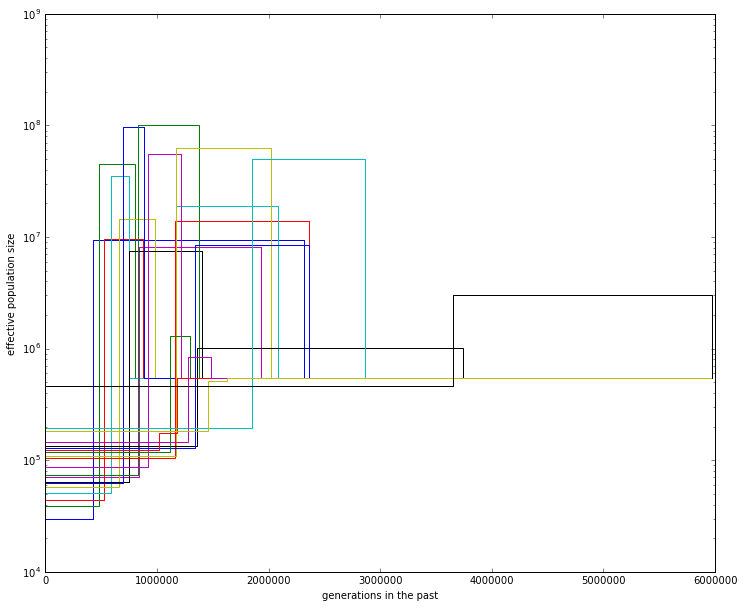

In [139]:
plt.rcParams['figure.figsize'] = [12.0, 10.0]

for run in zip(past, Tb_Tf_g, Tb_Tf_g, TF_g, TF_g, pres, anc, anc, nuB_n, nuB_n, nuF_n, nuF_n):
    plt.semilogy(run[:6], run[6:])
plt.xlabel('generations in the past')
plt.ylabel('effective population size')

# parallelus

In [14]:
%%px

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = fs_par # use PAR spectrum
perturb = True
fold = 3 # perturb randomly up to 6-fold
maxiter = 100 # run a maximum of 100 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_three_epoch/PAR_perturb" # set file name stub for opt. result files

In [103]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [16]:
# specify the initial parameter values, they will be randomly perturbed by up to a factor of 2 times `fold`
p0 = [1, 1, 1, 1]

ar_par = lbview.map(run_dadi, repeat(p0, 20), block=False, order=True)

In [23]:
ar_par.progress

18

In [25]:
ar_par.elapsed/60

22.79563685

I had to kill the last two long running jobs.

In [28]:
import glob

In [30]:
ar_par = []

for filename in glob.glob("OUT_three_epoch/PAR_perturb*.dill"):
    ar_par.append(dill.load(open(filename)))

In [31]:
get_flag_count(ar_par, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 12
unknown flag 0


Six optimisation converged.

In [34]:
i = 4 # index of flag with NM algorithm

successfull_popt = [flatten(out)[:9] for out in ar_par if out[1][i] == 0]

df = pd.DataFrame(data=successfull_popt, \
                  columns=['nuB_0', 'nuF_0', 'TB_0', 'TF_0', 'nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt', 'logL'])

df.sort_values(by='logL', ascending=True)

,nuB_0,nuF_0,TB_0,TF_0,nuB_opt,nuF_opt,TB_opt,TF_opt,logL
2,2.433394,0.438042,0.462081,2.612107,1.907850,0.038445,1.426696,2.480729,6925.673757
0,0.638494,0.283054,3.960000,1.212381,0.473253,0.027032,0.663347,1.317327,6925.673757
1,2.473569,0.361162,3.960000,0.920803,0.036822,0.001763,0.021552,0.781917,6925.673757
5,0.204874,0.193839,0.141559,1.090908,0.039256,0.007885,2.189611,1.059457,6925.673757
4,2.186779,0.569927,2.567862,2.802733,0.641334,0.104038,0.190060,3.830696,6925.673757
3,2.548660,0.202542,0.135508,3.459914,2.507626,0.091869,0.155196,3.829503,6925.673757


It would be nice to get a few more replicates for these results. I am going to use these optimal parameter combinations, perturb them randomly and use them as starting values for new optimisations.

In [35]:
df.loc[:, ['nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt']]

,nuB_opt,nuF_opt,TB_opt,TF_opt
0,0.473253,0.027032,0.663347,1.317327
1,0.036822,0.001763,0.021552,0.781917
2,1.907850,0.038445,1.426696,2.480729
3,2.507626,0.091869,0.155196,3.829503
4,0.641334,0.104038,0.190060,3.830696
5,0.039256,0.007885,2.189611,1.059457


In [40]:
# specify new set initial parameter values (the optimal sets repeated 3 times)

p0 = []

for _ in range(3):
    p0.extend(np.array(df.loc[:, ['nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt']]))

p0

[array([ 0.47325277,  0.0270319 ,  0.66334729,  1.31732675]),
 array([ 0.03682158,  0.00176323,  0.02155165,  0.78191672]),
 array([ 1.90784959,  0.03844487,  1.42669581,  2.48072912]),
 array([ 2.50762601,  0.09186928,  0.15519576,  3.82950266]),
 array([ 0.64133354,  0.10403757,  0.19006035,  3.83069627]),
 array([ 0.03925564,  0.00788456,  2.18961142,  1.05945703]),
 array([ 0.47325277,  0.0270319 ,  0.66334729,  1.31732675]),
 array([ 0.03682158,  0.00176323,  0.02155165,  0.78191672]),
 array([ 1.90784959,  0.03844487,  1.42669581,  2.48072912]),
 array([ 2.50762601,  0.09186928,  0.15519576,  3.82950266]),
 array([ 0.64133354,  0.10403757,  0.19006035,  3.83069627]),
 array([ 0.03925564,  0.00788456,  2.18961142,  1.05945703]),
 array([ 0.47325277,  0.0270319 ,  0.66334729,  1.31732675]),
 array([ 0.03682158,  0.00176323,  0.02155165,  0.78191672]),
 array([ 1.90784959,  0.03844487,  1.42669581,  2.48072912]),
 array([ 2.50762601,  0.09186928,  0.15519576,  3.82950266]),
 array([

In [41]:
%%px

fold = 2 # perturb up to 4 times

In [42]:
# run optimisations

ar_par_2 = lbview.map(run_dadi, p0, block=False, order=True)

In [48]:
ar_par_2.progress

18

In [49]:
get_flag_count(ar_par_2, NM=True)

success 18
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 0
unknown flag 0


Wow! All 18 runs were successful?!

In [87]:
# add new output to previous output
successfull_popt.extend( [flatten(out)[:9] for out in ar_par_2 if out[1][4] == 0] )

# create data frame
df = pd.DataFrame(data=successfull_popt, \
                  columns=['nuB_0', 'nuF_0', 'TB_0', 'TF_0', 'nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt', 'logL'])

# sort data frame by negative log likelihood
df.sort_values(by='nuF_opt', ascending=True)

,nuB_0,nuF_0,TB_0,TF_0,nuB_opt,nuF_opt,TB_opt,TF_opt,logL
25,0.034798,0.000622,0.034582,0.378960,0.032141,0.001058,0.032899,0.358150,6925.673757
7,0.034798,0.000622,0.034582,0.378960,0.032141,0.001058,0.032899,0.358150,6925.673757
31,0.021137,0.001603,0.035116,0.201532,0.021004,0.001120,0.036850,0.197136,6925.673757
13,0.021137,0.001603,0.035116,0.201532,0.021004,0.001120,0.036850,0.197136,6925.673757
1,2.473569,0.361162,3.960000,0.920803,0.036822,0.001763,0.021552,0.781917,6925.673757
11,0.046882,0.005830,3.960000,3.341567,0.047762,0.004537,3.913243,3.408379,6925.673757
29,0.046882,0.005830,3.960000,3.341567,0.047762,0.004537,3.913243,3.408379,6925.673757
19,0.029536,0.006689,0.029136,0.560299,0.026678,0.006358,0.028909,0.558054,6925.673757
37,0.029536,0.006689,0.029136,0.560299,0.026678,0.006358,0.028909,0.558054,6925.673757
23,0.010834,0.006921,0.784781,1.005371,0.010929,0.006721,0.784020,1.005448,6925.673757


I am going to visualise these population size histories.

In [57]:
# add time for ancient size change

df['TB+TF'] = pd.Series(df['TB_opt']+df['TF_opt'])

In [58]:
# extract columns from table
nuB = df.loc[:,'nuB_opt']
nuF = df.loc[:, 'nuF_opt']
Tb_Tf = df.loc[:, 'TB+TF']
TF = df.loc[:, 'TF_opt']

In [59]:
# calculate reference (ancient) population size from theta estimate (derived elsewhere by fitting a neutral spectrum)

theta_par = 10632.738922047551
mu = 3e-9
L = fs_par.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the ery spectrum is {0:,}.".format(int(L))
N_ref_par = theta_par/L/mu/4

The total sequence length for the ery spectrum is 1,214,938.


In [60]:
# turn nu into absolute Ne and T into generations

nuB_n = nuB*N_ref_par
nuF_n = nuF*N_ref_par
Tb_Tf_g = Tb_Tf*2*N_ref_par
TF_g = TF*2*N_ref_par

In [61]:
anc = [N_ref_par] * len(nuB)
pres = [1] * len(nuB)
past = [max(Tb_Tf_g)+1000] * len(nuB)

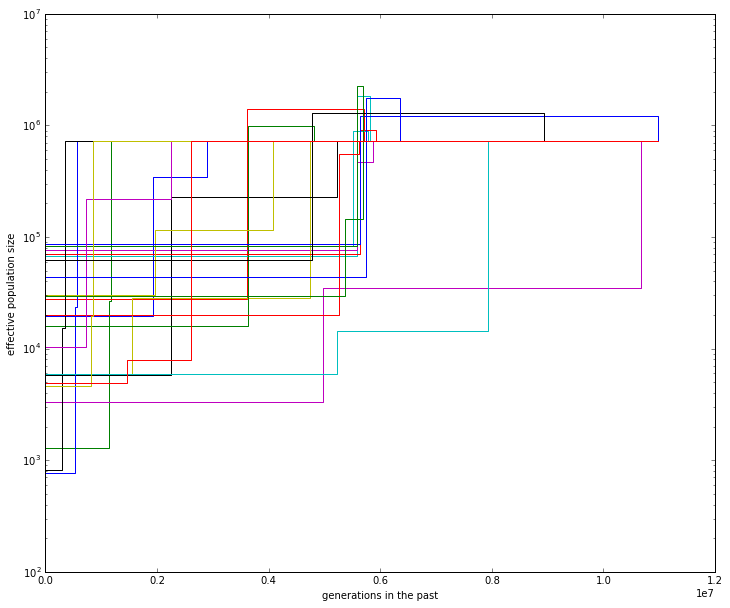

In [62]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [12.0, 10.0]

for run in zip(past, Tb_Tf_g, Tb_Tf_g, TF_g, TF_g, pres, anc, anc, nuB_n, nuB_n, nuF_n, nuF_n):
    plt.semilogy(run[:6], run[6:])
plt.xlabel('generations in the past')
plt.ylabel('effective population size')

The ancient size change is generally inferred to be more than 1 million generations ago (even up to 10 million)?!

Are the strength of the first population size change, $(\frac{1}{\nu_B})^{TB}$, and the strength of the second population size change, $(\frac{1}{\nu_F})^{TF}$, correlated with each other?

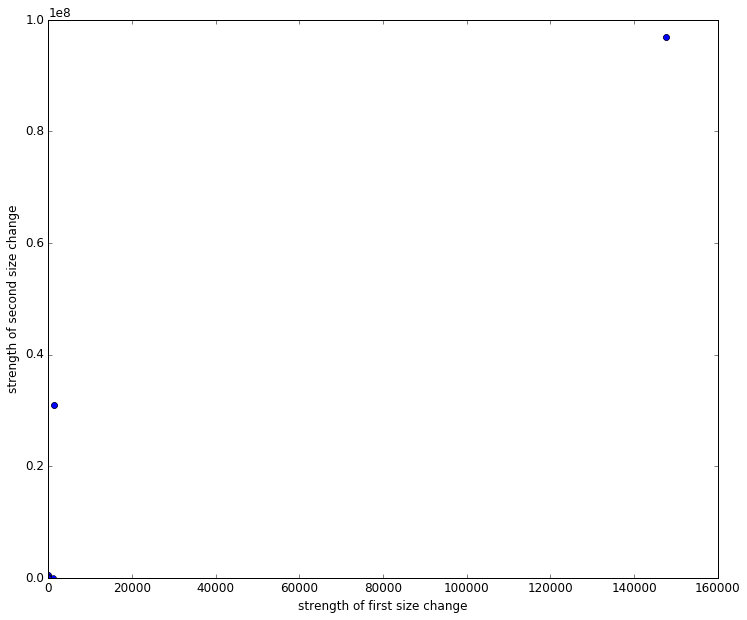

In [90]:
plt.rcParams['font.size'] = 12.0

plt.plot((1.0/df['nuB_opt'])**df['TB_opt'], (1.0/df['nuF_opt'])**df['TF_opt'], 'bo')
plt.xlabel('strength of first size change')
plt.ylabel('strength of second size change')

There is no correlation between the strength of the two size changes.

In [54]:
import dill

dump_this = ar_par
dump_this.extend(list(ar_par_2.get()))

dill.dump(dump_this, open("OUT_three_epoch/PAR_perturb_ar_par.dill", "w"))

In [55]:
p0 = [100, 1e-2, 1, 2] # start from more extreme initial parameter values

ar_par_3 = lbview.map(run_dadi, repeat(p0, 10), block = False, order=False)

In [67]:
ar_par_3.progress

10

In [68]:
get_flag_count(ar_par_3, NM=True)

success 10
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 0
unknown flag 0


In [93]:
dill.dump(list(ar_par_3.get()), open("OUT_three_epoch/PAR_perturb_extreme_ar_par.dill", "w"))

In [70]:
# add new output to previous output
successfull_popt_3 =  [flatten(out)[:9] for out in ar_par_3 if out[1][4] == 0]

# create data frame
df_3 = pd.DataFrame(data=successfull_popt_3, \
                  columns=['nuB_0', 'nuF_0', 'TB_0', 'TF_0', 'nuB_opt', 'nuF_opt', 'TB_opt', 'TF_opt', 'logL'])

# sort data frame by negative log likelihood
df_3.sort_values(by='logL', ascending=True)

,nuB_0,nuF_0,TB_0,TF_0,nuB_opt,nuF_opt,TB_opt,TF_opt,logL
4,268.347228,0.036617,3.495306,2.235183,225.289543,0.032213,3.451690,2.183728,6925.673757
3,38.559230,0.005461,1.235253,3.883301,41.390244,0.005079,1.240099,3.769861,6925.673757
2,67.498147,0.015576,1.088031,3.551166,63.945996,0.014691,1.088717,3.584231,6925.673757
5,48.901243,0.028192,1.874433,1.116714,56.580841,0.030822,1.919122,1.112101,6925.673757
1,27.733009,0.003506,3.201122,1.346019,30.203574,0.003972,3.091384,1.362643,6925.673757
9,155.267088,0.002844,1.982512,0.713019,155.438528,0.002252,1.990211,0.713649,6925.673757
6,53.472143,0.007924,3.721429,3.367482,59.768349,0.007426,3.747301,3.356914,6925.673757
8,261.612644,0.005875,0.776384,3.960000,290.395553,0.004657,0.779946,3.904082,6925.673757
0,41.386654,0.004065,1.411848,1.871907,44.738775,0.005076,1.414354,1.917174,6925.673757
7,316.920444,0.007079,0.612435,3.960000,315.270535,0.005561,0.615180,3.948950,6925.673757


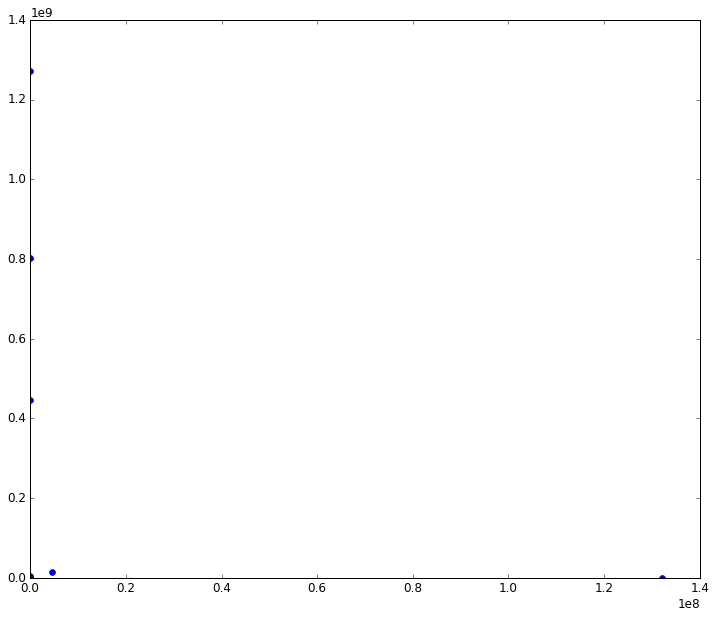

In [92]:
plt.plot(df_3['nuB_opt']**df_3['TB_opt'], (1.0/df_3['nuF_opt'])**df_3['TF_opt'], 'bo')

I cannot see a correlation here either.

---

All optimisations consistently show a reduction in the contemporary population size with respect to the ancient population size ($\nu_F$). The ancient population size change is much less clear and ranges from a reduction by one half to a doubling. Also this event is inferred to have occurred quite distant in the past, at $(T_F + T_B) \times 2N_{ref}$ generations in the past. This makes me think that this ancient size change cannot reliably be inferred. There only seems to be evidence for one size change.

My attempts to fit a two epoch model (i. e. a single size change) to the _parallelus_ 1D SFS had previously failed due to inferred parameter values hitting ever more extreme parameter limits. Given that I was able to reasonably fit a 4 parameter model to the 1D SFS of _parallelus_ (that does not show strong evidence for two size changes), I would be surprised if it wasn't possible to fit the two epoch model to the _parallelus_ spectrum.

## retry two_epoch model with PAR spectrum

In [1]:
%who

Interactive namespace is empty.


In [2]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [3]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy as np

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

In [4]:
%%px --local

# create link to function that specifies the model
func = dadi.Demographics1D.two_epoch

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

In [5]:
%%px --local

# import 1D spectrum of ery on all engines:
fs_ery = dadi.Spectrum.from_file('ERY.unfolded.sfs').fold()

# import 1D spectrum of ery on all engines:
fs_par = dadi.Spectrum.from_file('PAR.unfolded.sfs').fold()

In [6]:
%%px

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = fs_par # use PAR spectrum
perturb = True
fold = 2 # perturb randomly up to 6-fold
maxiter = 100 # run a maximum of 100 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_two_epoch/PAR_perturb" # set file name stub for opt. result files

# set lower and upper bounds to nu and T
upper_bound = [1e4, 5]
lower_bound = [1e-4, 0]

ns = fs_ery.sample_sizes # both populations have the same sample size

fs_ery.pop_ids = ['ery']
fs_par.pop_ids = ['par']

# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [50, 60, 70]

In [7]:
lbview = cl.load_balanced_view()

In [32]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [9]:
from itertools import repeat

In [10]:
# specify the initial parameter values, they will be randomly perturbed by up to a factor of 4
p0 = [0.1, 2.5]

ar_par_te = lbview.map(run_dadi, repeat(p0, 20), block=False, order=True)

In [14]:
ar_par_te.progress

19

In [13]:
def get_flag_count(out, NM=True):
    """
    out: list of tuples, each containing p_init and popt + additional info, including warnflags
    as produced by run_dadi.py
    """
    from collections import defaultdict
    
    if NM: # if ar from Nelder-Mead
        i = 4 # the warnflag is reported at index position 4 in the output array
    else: # ar from BFGS optimisation
        i = 6
    
    warnflag = defaultdict(int)

    for res in out:
        if res[1][i] == 1: # notice the change in indexing
            warnflag[1] +=1
        elif res[1][i] == 2:
            warnflag[2] += 1
        elif res[1][i] == 0:
            warnflag[0] += 1
        else:
            warnflag[999] +=1
    if NM:
        print "success", warnflag[0]
        print "Maximum number of function evaluations made.", warnflag[1]
        print "Maximum number of iterations reached.", warnflag[2]
        print "unknown flag", warnflag[999]
    else:
        print "success", warnflag[0]
        print "Maximum number of iterations exceeded.", warnflag[1]
        print "Gradient and/or function calls not changing.", warnflag[2]
        print "unknown flag", warnflag[999]

In [16]:
ar_par_te = []

import glob, dill

for filename in glob.glob("OUT_two_epoch/PAR_perturb*dill"):
    ar_par_te.append( dill.load(open(filename)) )

In [17]:
get_flag_count(ar_par_te, NM=True)

success 21
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 0
unknown flag 0


In [18]:
def flatten(array):
    """
        Returns a list of flattened elements of every inner lists (or tuples)
        ****RECURSIVE****
    """
    import numpy
    res = []
    for el in array:
        if isinstance(el, (list, tuple, numpy.ndarray)):
            res.extend(flatten(el))
            continue
        res.append(el)
    return list( res )

In [19]:
import pandas as pd

In [20]:
i = 4 # index of flag with NM algorithm

successfull_popt = [flatten(out)[:5] for out in ar_par_te if out[1][i] == 0]

df = pd.DataFrame(data=successfull_popt, \
                  columns=['nu_0','T_0', 'nu_opt', 'T_opt', 'logL'])

df.sort_values(by='logL', ascending=True)

,nu_0,T_0,nu_opt,T_opt,logL
10,0.043733,0.843860,0.015968,0.884924,6925.673757
7,0.031110,4.950000,0.021988,4.615473,6925.673757
3,0.027317,3.411201,0.015919,3.747210,6925.673757
12,0.339826,3.022905,0.111238,4.938315,6925.673757
9,0.225660,2.139018,0.017545,2.814009,6925.673757
17,0.046077,2.321844,0.039505,2.421725,6925.673757
16,0.043962,2.319764,0.060086,2.464394,6925.673757
4,0.035152,1.289873,0.032329,1.289937,6925.673757
13,0.227686,1.491931,0.007004,1.933539,6925.673757
18,0.042434,4.950000,0.033626,4.175495,6925.673757


Note that these two epoch models have the same likelihood as the three epoch models above.

In [21]:
# specify the initial parameter values, they will be randomly perturbed by up to a factor of 4
p0 = [10, 0.5]

ar_par_te = lbview.map(run_dadi, repeat(p0, 20), block=False, order=True)

In [22]:
ar_par_te.progress

20

In [24]:
get_flag_count(ar_par_te, NM=True)

success 20
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 0
unknown flag 0


In [25]:
i = 4 # index of flag with NM algorithm

successfull_popt = [flatten(out)[:5] for out in ar_par_te if out[1][i] == 0]

df = pd.DataFrame(data=successfull_popt, \
                  columns=['nu_0','T_0', 'nu_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu_0,T_0,nu_opt,T_opt,logL
1,6.987489,1.642464,6.645270,5.000000,5504.381047
18,24.561703,0.229637,6.645150,4.999997,5504.381050
16,3.503846,0.197141,6.644959,4.999996,5504.381051
4,3.107369,0.694274,6.644691,4.999998,5504.381051
12,4.198500,1.480943,6.644962,4.999994,5504.381056
15,14.315275,0.361328,6.644621,4.999997,5504.381058
7,4.502252,0.168670,6.644580,4.999996,5504.381061
6,4.123402,1.026289,6.645491,4.999999,5504.381061
13,11.232949,0.650673,6.644530,4.999996,5504.381063
10,12.362184,1.272441,6.644494,4.999996,5504.381067


The likelihood of these parameter values is much higher than the the ones above. However, the time parameter is hitting the upper boundary.

In [35]:
%%px

upper_bound = [1e4, 6]

In [36]:
# specify the initial parameter values, they will be randomly perturbed by up to a factor of 4
p0 = [1, 1]

ar_par_te = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [28]:
#ar_par_te = []

#import glob, dill

#for filename in glob.glob("OUT_two_epoch/PAR_perturb*dill"):
#    ar_par_te.append( dill.load(open(filename)) )

In [37]:
get_flag_count(ar_par_te, NM=True)

success 10
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 0
unknown flag 0


In [38]:
i = 4 # index of flag with NM algorithm

successfull_popt = [flatten(out)[:5] for out in ar_par_te if out[1][i] == 0]

df = pd.DataFrame(data=successfull_popt, \
                  columns=['nu_0','T_0', 'nu_opt', 'T_opt', 'logL'])

df.sort_values(by='logL', ascending=True)

,nu_0,T_0,nu_opt,T_opt,logL
7,3.809859,0.880742,7.723638,5.999997,5502.338651
6,3.960114,0.730363,7.723791,5.999995,5502.338651
3,0.946438,3.628840,7.724187,5.999994,5502.338653
1,1.099448,1.424327,7.723607,5.999982,5502.338675
8,1.268052,0.301753,7.724743,5.999970,5502.338719
5,0.478007,0.297796,7.731477,5.999997,5502.341217
2,1.163708,3.434724,7.690900,5.999987,5502.388130
0,0.426545,2.386989,0.146739,5.883732,6925.673757
4,0.291222,0.328804,0.124747,5.466190,6925.673757
9,0.322324,0.444581,0.046371,3.658299,6925.673757


In [40]:
dill.dump(list(ar_par_te.get()), open("OUT_two_epoch/PAR_perturb_ar_par.dill", "w"))

It is very hard for me to believe that the log likelihood of all parameter combinations is almost exactly the same AND also the same as the likelihood for all parameter combinations of the three epoch model above!

In [92]:
[get_ll(out[1][0]) for out in ar_par_te if out[1][4] == 0]

[-9825.1799565799647,
 -9825.1799565806832,
 -9825.1799565812507,
 -9825.1799565812271,
 -9825.1799565805759,
 -9825.1799565808014,
 -9825.1799565800939,
 -9825.1799565815054,
 -9825.1799565804031,
 -9825.1799565808542,
 -9825.1799565807978,
 -9825.1799565798756,
 -9825.1799565810798,
 -9825.179956580927,
 -9825.179956580072,
 -9825.1799565812707,
 -9825.1799565804686,
 -9825.1799565797955,
 -9825.1799565801703,
 -9825.1799565808396]

In [93]:
ar_par_te.get()

[(array([ 0.05486992,  1.99860381]),
  (array([ 0.03180292,  1.95648193]), 9825.1799565799647, 24, 62, 0)),
 (array([ 0.07135217,  3.50371679]),
  (array([ 0.06243178,  3.50071502]), 9825.1799565806832, 19, 52, 0)),
 (array([ 0.05054308,  2.05085516]),
  (array([ 0.04690783,  2.05099452]), 9825.1799565812507, 14, 45, 0)),
 (array([ 0.08349208,  3.96      ]),
  (array([ 0.08365293,  3.82117106]), 9825.1799565812271, 25, 59, 0)),
 (array([ 0.08232057,  3.2093796 ]),
  (array([ 0.09182442,  3.43965861]), 9825.1799565805759, 20, 58, 0)),
 (array([ 0.06735758,  2.9487646 ]),
  (array([ 0.07978079,  3.09333988]), 9825.1799565808014, 21, 54, 0)),
 (array([ 0.0727572,  3.96     ]),
  (array([ 0.07595359,  3.85083138]), 9825.1799565800939, 18, 53, 0)),
 (array([ 0.14681914,  3.76597664]),
  (array([ 0.10123876,  3.87681382]), 9825.1799565815054, 23, 65, 0)),
 (array([ 0.07298845,  3.60220333]),
  (array([ 0.04928812,  3.3752426 ]), 9825.1799565804031, 18, 55, 0)),
 (array([ 0.06802161,  3.29320

In [94]:
from scipy.optimize import fmin

In [95]:
?fmin

`fopt` is the likelihood of the otimal parameter combination. I therefore don't need to calculate the likelihood with `get_ll`. It's already returned by the optimisation function.

OK. it may be that the likelihood values are correct and that there is a ridge in the likelihood surface.

# retry two_epoch model with ery spectrum

I previously also wasn't able to find reasonable optimal parameter values for the two epoch model with the _erythropus_ spectrum. I want to make another attempt here, given the apparently successful optimisation for the three epoch model above.

In [99]:
%%px

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = fs_ery # use ERY spectrum
perturb = True
fold = 1
maxiter = 100 # run a maximum of 100 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)

In [100]:
# specify the initial parameter values, they will be randomly perturbed by up to a factor of 2
p0 = [1, 1]

ar_ery_te = lbview.map(run_dadi, repeat(p0, 20), block=False, order=True)

In [101]:
ar_ery_te.elapsed

13.159561

In [102]:
get_flag_count(ar_ery_te, NM=True)

success 5
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 15
unknown flag 0


In [103]:
ar_ery_te.get()[0]

(array([ 1.79926927,  1.68949312]),
 (array([  1.00492187e-04,   2.17110737e-06]),
  2040.4927381782597,
  100,
  184,
  2))

In [105]:
successfull_popt_ery_te = [flatten(out)[:5] for out in ar_ery_te if out[1][4] == 0]
df = pd.DataFrame(data=successfull_popt_ery_te, \
                  columns=['nuB_0', 'T_0', 'nuB_opt', 'T_opt', 'logL'])
df.sort_values(by='logL', ascending=False)

,nuB_0,T_0,nuB_opt,T_opt,logL
0,1.008790,1.448122,0.0001,0.000002,2040.492674
4,0.863051,0.745958,0.0001,0.000002,2040.492674
3,0.974539,0.509961,0.0001,0.000002,2040.492674
2,0.973070,1.668159,0.0001,0.000002,2040.492674
1,1.289495,0.638957,0.0001,0.000002,2040.492674


These parameters are hitting the parameter limits set above and therefore cannot be regarded as converged.

In [106]:
# specify the initial parameter values, they will be randomly perturbed by up to a factor of 2
p0 = [0.1, 0.001]

ar_ery_te = lbview.map(run_dadi, repeat(p0, 20), block=False, order=True)

In [107]:
get_flag_count(ar_ery_te, NM=True)

success 20
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 0
unknown flag 0


Oho!

In [108]:
successfull_popt_ery_te = [flatten(out)[:5] for out in ar_ery_te if out[1][4] == 0]
df = pd.DataFrame(data=successfull_popt_ery_te, \
                  columns=['nuB_0', 'T_0', 'nuB_opt', 'T_opt', 'logL'])
df.sort_values(by='logL', ascending=False)

,nuB_0,T_0,nuB_opt,T_opt,logL
15,0.123444,0.000651,0.0001,0.000002,2040.492742
4,0.156333,0.001206,0.0001,0.000002,2040.492681
16,0.125851,0.000929,0.0001,0.000002,2040.492674
19,0.062718,0.001864,0.0001,0.000002,2040.492674
0,0.132941,0.000502,0.0001,0.000002,2040.492674
1,0.166737,0.001820,0.0001,0.000002,2040.492674
10,0.096480,0.000572,0.0001,0.000002,2040.492674
18,0.064284,0.000917,0.0001,0.000002,2040.492674
9,0.124843,0.000887,0.0001,0.000002,2040.492674
13,0.058069,0.000997,0.0001,0.000002,2040.492674


Still no luck. It really looks as though the two epoch model cannot be fit to the _erythropus_ spectrum.